Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :) 📓 This repository/notebook serves as a personal reminder for me, documenting code snippets and techniques sourced from various learning resources. The goal is to consolidate valuable information and create a basic reference guide. Please note that the codes included here are not originally mine, and credit goes to the respective authors and resources. Feel free to explore and use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://huggingface.co/docs/diffusers/tutorials/using_peft_for_inference
    * https://huggingface.co/docs/diffusers/stable_diffusion
    
    
#### Purpose :
    * Using PEFT
    
#### Keywords :
    * diffusion model 
    * PEFT
    * LoRA

There are many adapters (with LoRAs being the most common type) trained in different styles to achieve different effects. You can even combine multiple adapters to create new and unique images. With the 🤗 PEFT integration in 🤗 Diffusers, it is really easy to load and manage adapters for inference. In this guide, you’ll learn how to use different adapters with Stable Diffusion XL (SDXL) for inference.

In [1]:
from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

C:\Users\Zeki\anaconda3\envs\stable_diff\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zeki\anaconda3\envs\stable_diff\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\Zeki\anaconda3\envs\stable_diff\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]


In [2]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Zeki\anaconda3\envs\stable_diff\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 30/30 [02:25<00:00,  4.86s/it]


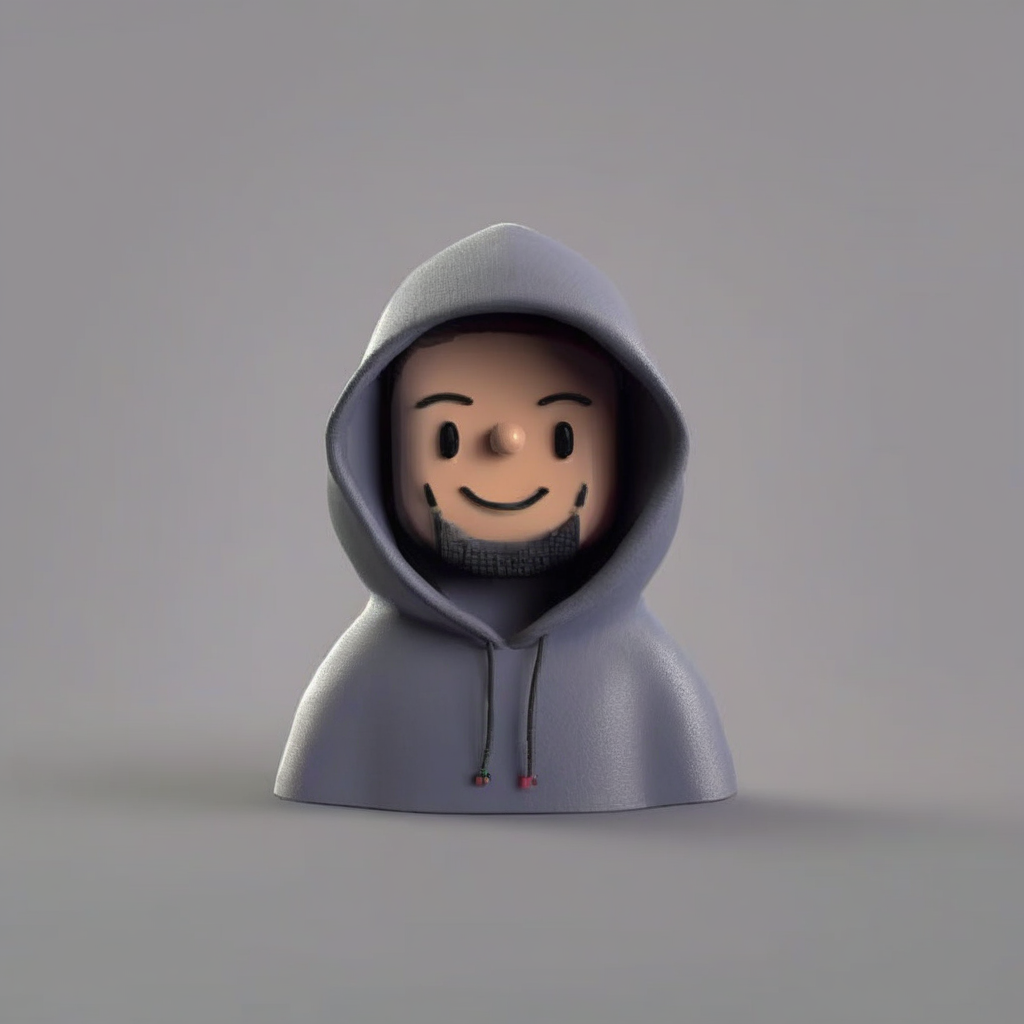

In [3]:
prompt = "toy_face of a hacker with a hoodie"

lora_scale= 0.9
image = pipe(prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)).images[0]
image

use another loRA..make necessary changes..

In [4]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

pixel-art-xl.safetensors: 100%|██████████| 171M/171M [00:32<00:00, 5.26MB/s] 


100%|██████████| 30/30 [03:42<00:00,  7.42s/it]


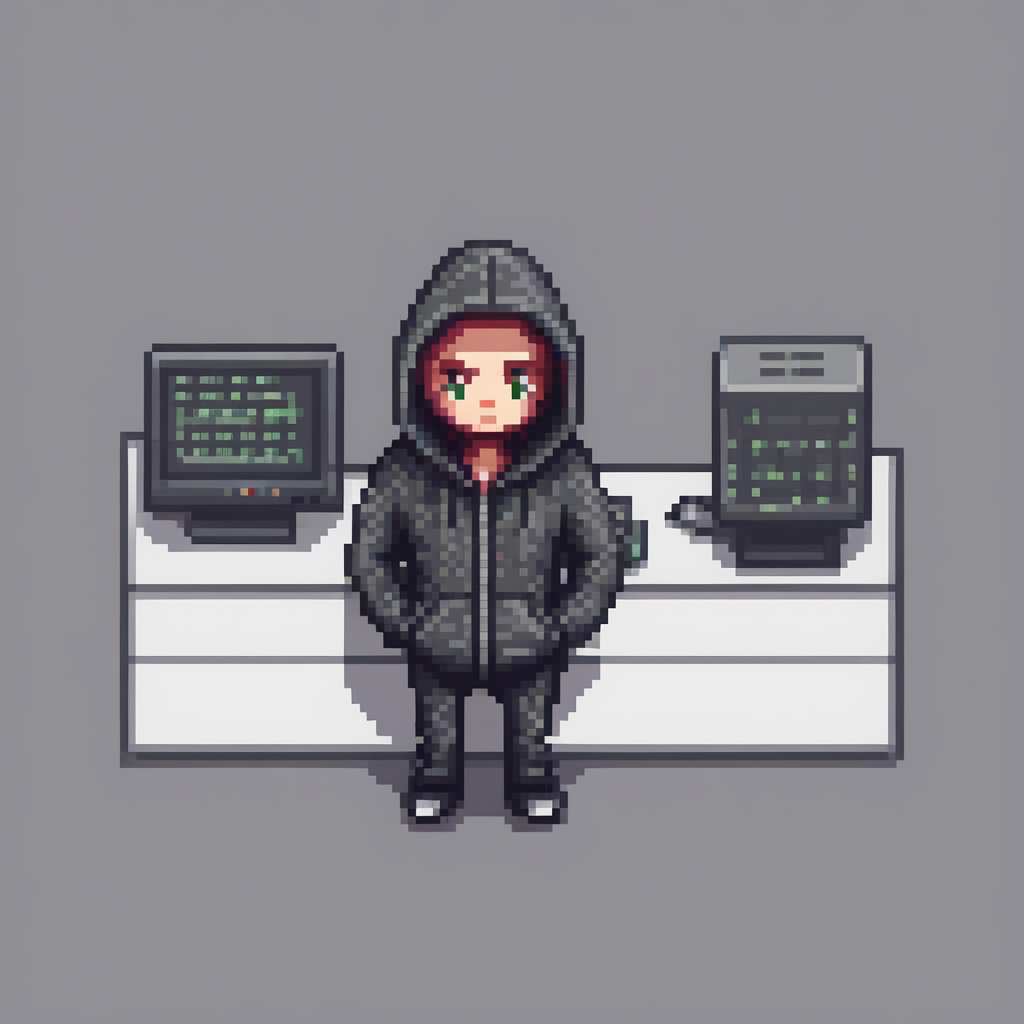

In [5]:
prompt = "a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

You can also perform multi-adapter inference where you combine different adapter checkpoints for inference.

In [6]:
pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

!!! careful about using trigger words while writing propmt. Most of LoRAs are trained by DreamBooth and training often relies on “trigger” words in the input text prompts in order for the generation results to look as expected.

100%|██████████| 30/30 [03:15<00:00,  6.52s/it]


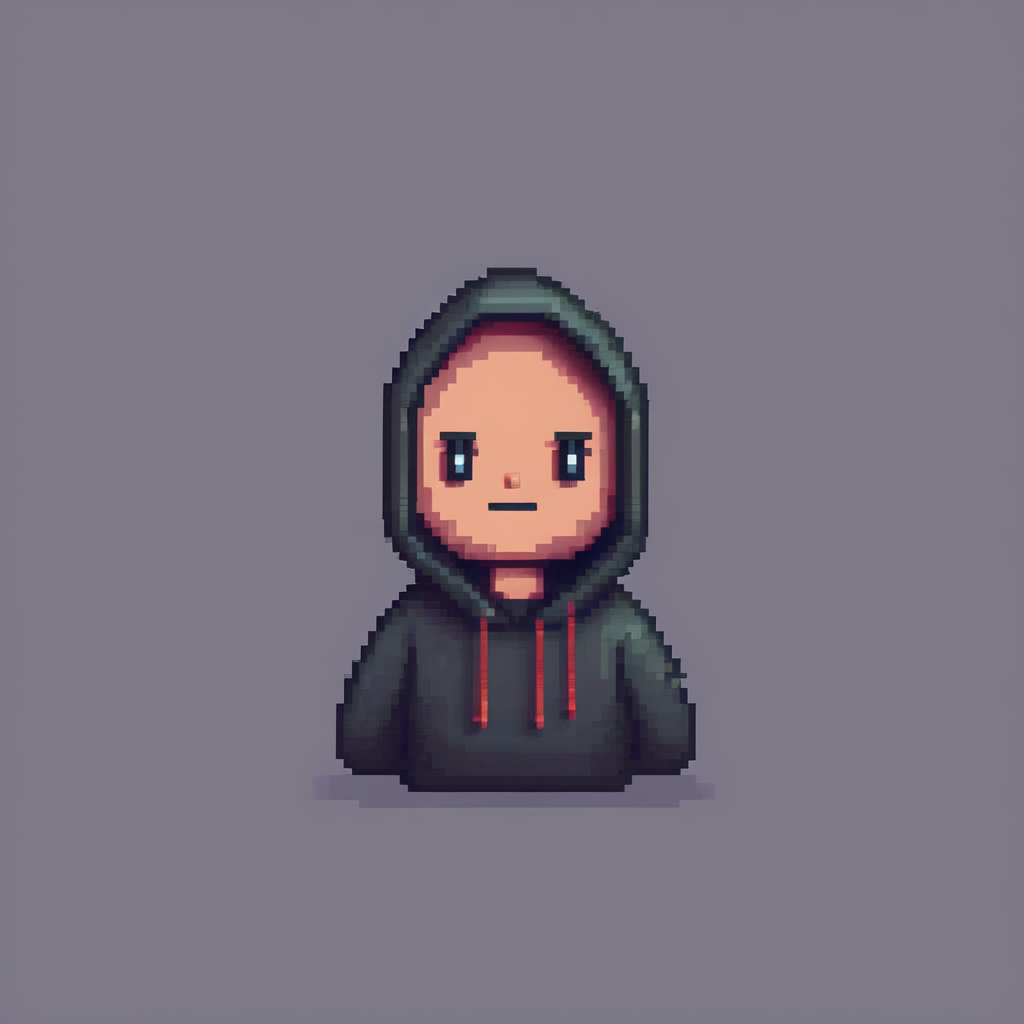

In [7]:
# Notice how the prompt is constructed.
prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]
image

disable all LoRAs

100%|██████████| 30/30 [02:28<00:00,  4.93s/it]


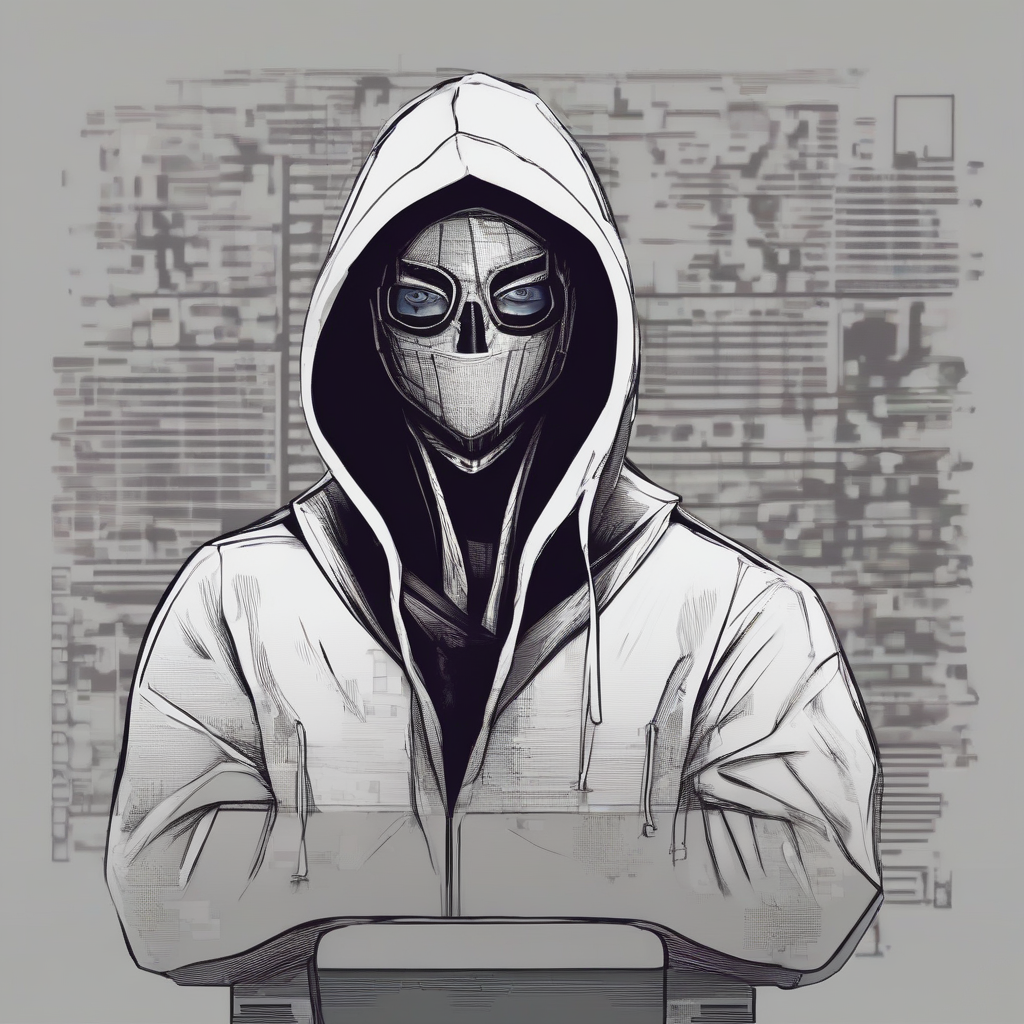

In [8]:
pipe.disable_lora()

prompt = "toy_face of a hacker with a hoodie"
lora_scale= 0.9
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

In [9]:
active_adapters = pipe.get_active_adapters()
active_adapters
["toy", "pixel"]

['toy', 'pixel']

In [10]:
list_adapters_component_wise = pipe.get_list_adapters()
list_adapters_component_wise
{"text_encoder": ["toy", "pixel"], "unet": ["toy", "pixel"], "text_encoder_2": ["toy", "pixel"]}

{'text_encoder': ['toy', 'pixel'],
 'unet': ['toy', 'pixel'],
 'text_encoder_2': ['toy', 'pixel']}

fuse/unfuse multiple adapters directly into the model weights (both UNet and text encoder) using the fuse_lora() method, which can lead to a speed-up in inference and lower VRAM usage.

In [12]:
#pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
#pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])
# Fuses the LoRAs into the Unet
pipe.fuse_lora()

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]



100%|██████████| 30/30 [03:19<00:00,  6.64s/it]


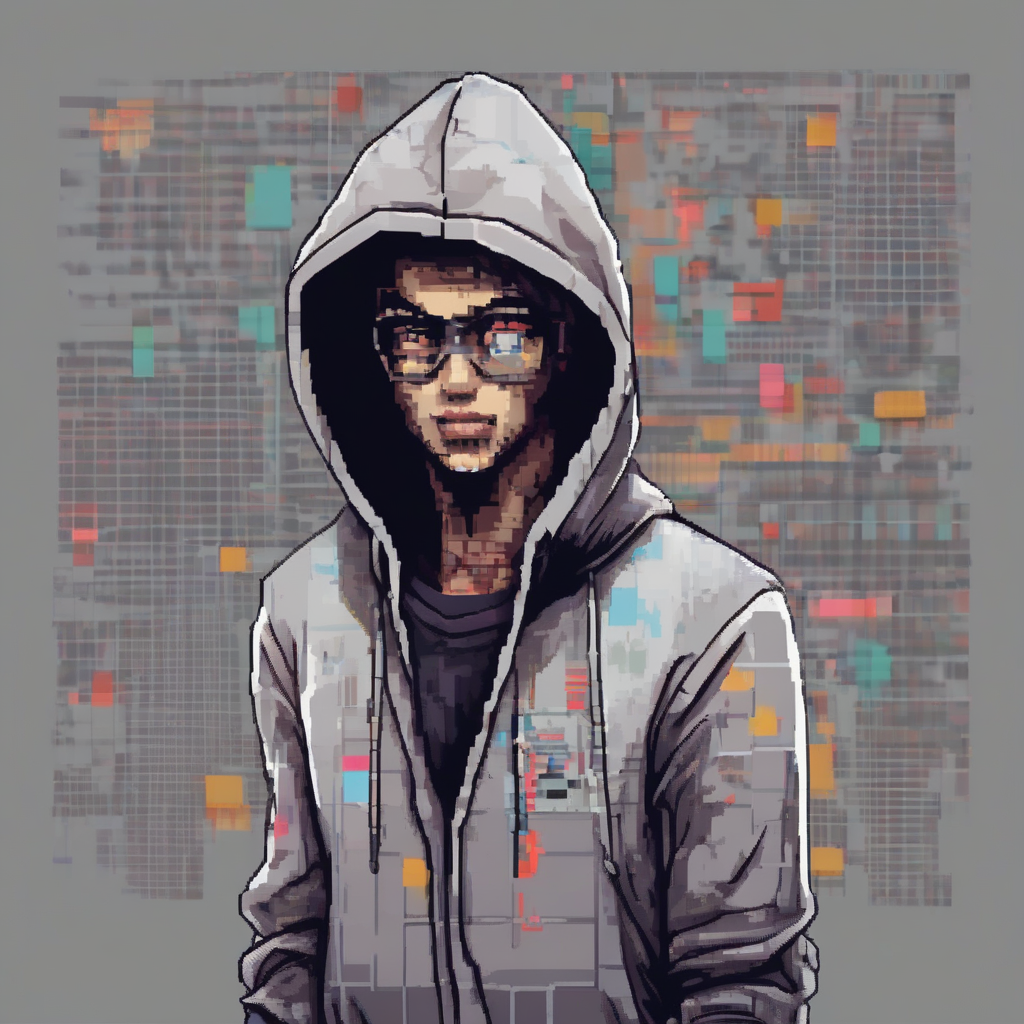

In [13]:
image

In [ ]:
# Gets the Unet back to the original state
pipe.unfuse_lora()

save LoRA for serialization

In [14]:
pipe.fuse_lora(lora_scale=1.0)
pipe.unload_lora_weights()
pipe.save_pretrained("lora_saving")

The current API is supported for operating with a single LoRA file. You are trying to load and fuse more than one LoRA which is not well-supported.


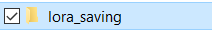